# Neural Networks

*Adapted from `pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html`.*

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
MNIST, CIFAR. In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.


In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data", # Path where data is stored
    train=True, # Training or test dataset
    download=True, # Download the data if not available locally
    transform=ToTensor(), # Feature transformations (convert images to tensors)
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e., each element
in the dataloader iterable will return a batch of 64 features and labels.



In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [ ]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

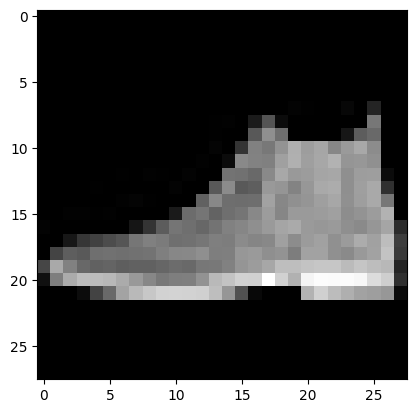

In [ ]:
import matplotlib.pyplot as plt
print(X[0])
plt.imshow(X[0,0], cmap="gray")

To define a neural network in PyTorch, we use`nn.Sequential` and define the layers of the network. The `torch.nn` namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the `nn.Module` and a neural network is a module itself that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

To accelerate operations in the neural network, we move it to the GPU if available.


In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")


Using cpu


In [ ]:
# Define model
model = nn.Sequential( # Ordered container of modules
    nn.Flatten(), # Convert the 28x28 matrix of pixels into an array of length 784
    nn.Linear(28*28, 512), # Apply a linear transformation on the input using weights and biases
    nn.ReLU(), # Non-linear activation
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
).to(device)

print(model) # Print the structure of the neural network

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)


To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).

In [ ]:
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Pass model parameters to optimizer

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    '''
    This function implements the train loop. It iterates over the training dataset
    and try to converge to optimal parameters.
    '''
    size = len(dataloader.dataset)
    model.train() # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X) # Pass the data to the model to execute the model forward
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward() # Compute gradients of the loss w.r.t parameters (backward pass)
        optimizer.step() # Do a gradient descent step and adjust parameters
        optimizer.zero_grad() # Reset the gradients of model parameters to zero (gradients by default add up)

        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.


In [ ]:
def test(dataloader, model, loss_fn):
    '''
    This function implements the validation/test loop. It iterates over the test
    dataset to check if the model performance is improving.
    '''
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set the model to evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad(): # Do not track gradients while evaluating (faster)
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # Compute CE loss on the batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # Compute classification error
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
epochs = 8
for t in range(epochs):
    print(f"Epoch {t+1}\n")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1

loss: 2.306128  [   64/60000]
loss: 2.280684  [12864/60000]
loss: 2.261307  [25664/60000]
loss: 2.219860  [38464/60000]
loss: 2.193163  [51264/60000]
Test Error: 
 Accuracy: 39.1%, Avg loss: 2.162672 

Epoch 2

loss: 2.145481  [   64/60000]
loss: 2.120371  [12864/60000]
loss: 2.078746  [25664/60000]
loss: 2.022705  [38464/60000]
loss: 1.927360  [51264/60000]
Test Error: 
 Accuracy: 53.7%, Avg loss: 1.897353 

Epoch 3

loss: 1.841493  [   64/60000]
loss: 1.792072  [12864/60000]
loss: 1.712483  [25664/60000]
loss: 1.616178  [38464/60000]
loss: 1.579550  [51264/60000]
Test Error: 
 Accuracy: 62.9%, Avg loss: 1.532495 

Epoch 4

loss: 1.539383  [   64/60000]
loss: 1.506407  [12864/60000]
loss: 1.400458  [25664/60000]
loss: 1.334926  [38464/60000]
loss: 1.255318  [51264/60000]
Test Error: 
 Accuracy: 65.0%, Avg loss: 1.262559 

Epoch 5

loss: 1.241133  [   64/60000]
loss: 1.178562  [12864/60000]
loss: 1.215059  [25664/60000]
loss: 1.147407  [38464/60000]
loss: 1.085750  [51264/6000

## Exercise: Searching for Supersymmetric Collisions with Neural Nets

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
!gunzip "/content/SUSY.csv.gz" # If you are using noto.epfl.ch, change this line to !gunzip "./SUSY.csv.gz"

The SUSY dataset consists of 5 million simulated Monte Carlo samples
of supersymmetric and non-supersymmetric collisions. The goal is to distinguish between a process
where new supersymmetric particles are produced and a background process. The first 8 features are
measurements of the final particle states, while the last 10 features are functions of the first 8 derived
by physicists to help to discriminate the events.

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets

We provide the class `SUSY_Dataset` to load the train and test datasets.

In [ ]:
class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            data_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            dataset_size (int): Size of the full dataset which is splitted in 80% for train and 20% for test.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only.
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2',
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        # Number of datapoints to work with
        df = pd.read_csv(root_dir+data_file, header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # Set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))

        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")

    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample

In [ ]:
training_data = SUSY_Dataset(
    data_file='SUSY.csv',
    root_dir='./',
    dataset_size=2000,
    train=True,
    )

test_data = SUSY_Dataset(
    data_file='SUSY.csv',
    root_dir='./',
    dataset_size=2000,
    train=False,
    )

1. To train our neural network with SGD, we want to pass the samples in batches. Build the train and
test data loaders, setting the batch size to 100 and activating reshuffling at each epoch for the train
data by setting `shuffle=True`.

2. Define a fully connected ReLU neural network taking an 18-dimensional input, with two hidden layers with 200 neurons, one hidden layer with 100 neurons, and a final linear layer with two outputs.

3. Using the cross-entropy loss and SGD with learning rate 1e-2, train the model for 100 epochs (if you are using noto.epfl.ch, you can train for 30 epochs only). You can use the train and test loops defined in the previous exercise.